# Automatic scoring of x-ray images

Import dependencies

In [1]:
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

# PIL to open & manipulate images
from PIL import Image, ImageOps, ImageChops

# for messages in loops
from IPython.display import clear_output

# to save arrays
import h5py

# for folder-timestamp
from datetime import datetime

# for train/test split
from sklearn.model_selection import train_test_split
# for one-hot encoding
from sklearn.preprocessing import LabelBinarizer
# for class weights
from sklearn.utils import class_weight
# for model evaluation
from sklearn.metrics import confusion_matrix, classification_report
# for efficient loops
import itertools


# keras
from tensorflow.python.keras import backend as K
from tensorflow.python.keras.utils import HDF5Matrix
from tensorflow.python.keras.models import Sequential, load_model
from tensorflow.python.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, \
    Dropout, Lambda, Activation, BatchNormalization
from tensorflow.python.keras.preprocessing.image import ImageDataGenerator
from tensorflow.python.keras import callbacks


Define image format & random seeds

In [2]:
# image format -> (rows, cols, channels)
K.set_image_data_format("channels_last")
# fix random seed for reproducibility
seed = 1
np.random.seed(seed)
tf.set_random_seed(seed)

Import data as HDF5 Matrix

In [3]:
# one hot encode labels

with h5py.File('/data/joint_scoring/labels_train_regression.h5', 'r') as hf:
    labels_train = hf['labels_train_regression'][:]
    
with h5py.File('/data/joint_scoring/labels_test_regression.h5', 'r') as hf:
    labels_test = hf['labels_test_regression'][:]
    
def cdf(label):
    arr = np.zeros(101)
    arr[int(label):] = 1
    return arr

labels_train = [cdf(x) for x in labels_train]
labels_test = [cdf(x) for x in labels_test]

In [4]:
labels_train = np.array(labels_train)
labels_test = np.array(labels_test)

In [5]:
print(labels_train.shape)
print(labels_test.shape)

(72625, 101)
(19709, 101)


In [6]:
with h5py.File('/data/joint_scoring/labels_train_regression_cdf.h5', 'w') as hf:
    hf.create_dataset("labels_train_regression_cdf",  data=labels_train)
    
with h5py.File('/data/joint_scoring/labels_test_regression_cdf.h5', 'w') as hf:
    hf.create_dataset("labels_test_regression_cdf",  data=labels_test)

In [7]:
img_train = HDF5Matrix('/data/joint_scoring/img_train_regression.h5', 'img_train_regression')
img_test = HDF5Matrix('/data/joint_scoring/img_test_regression.h5', 'img_test_regression')

labels_train = HDF5Matrix('/data/joint_scoring/labels_train_regression_cdf.h5', 'labels_train_regression_cdf')
labels_test = HDF5Matrix('/data/joint_scoring/labels_test_regression_cdf.h5', 'labels_test_regression_cdf')

In [8]:
def crps(y_true, y_pred):
    diff = (y_true - y_pred)
    diff_2 = K.square(diff)
    loss = K.mean(diff_2)
    return loss

## 2. Model

In [9]:
from tensorflow.python.keras.applications.inception_v3 import InceptionV3

In [10]:
model_1 = InceptionV3(include_top=False, weights='imagenet', input_shape=(150, 150, 3), pooling='avg')
model_1.summary()# adding custom output layer

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_1 (InputLayer)             (None, 150, 150, 3)   0                                            
____________________________________________________________________________________________________
conv2d_1 (Conv2D)                (None, 74, 74, 32)    864         input_1[0][0]                    
____________________________________________________________________________________________________
batch_normalization_1 (BatchNorm (None, 74, 74, 32)    96          conv2d_1[0][0]                   
____________________________________________________________________________________________________
activation_1 (Activation)        (None, 74, 74, 32)    0           batch_normalization_1[0][0]      
___________________________________________________________________________________________

In [11]:
x = model_1.output
x = Dense(units=1024, kernel_initializer="he_normal")(x)
x = BatchNormalization()(x)
x = Activation("relu")(x)
x = Dropout(rate=0.5)(x)
x = Dense(units=512, kernel_initializer="he_normal")(x)
x = BatchNormalization()(x)
x = Activation("relu")(x)
x = Dropout(rate=0.5)(x)
predictions = Dense(units=101, activation="sigmoid",
                    kernel_initializer="he_normal")(x)

In [12]:
from tensorflow.python.keras.models import Model
model = Model(inputs=model_1.input, outputs=predictions)

In [13]:
model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_1 (InputLayer)             (None, 150, 150, 3)   0                                            
____________________________________________________________________________________________________
conv2d_1 (Conv2D)                (None, 74, 74, 32)    864         input_1[0][0]                    
____________________________________________________________________________________________________
batch_normalization_1 (BatchNorm (None, 74, 74, 32)    96          conv2d_1[0][0]                   
____________________________________________________________________________________________________
activation_1 (Activation)        (None, 74, 74, 32)    0           batch_normalization_1[0][0]      
___________________________________________________________________________________________

In [14]:
from tensorflow.python.keras.optimizers import Adam
# learning rate 10 times smaller than usual
adam = Adam(lr=0.0001)

In [15]:
model.compile(optimizer=adam, loss=crps, metrics=["mae"])

In [16]:
len(model.layers)

321

In [17]:
for layer in model.layers[0:-10]:
    layer.trainable = False

In [18]:
# create log directory
now = datetime.now
new_folder = '{}'.format(now().strftime('%Y%m%d_%H%M%S'))

In [19]:
print(new_folder)

20171128_000703


In [20]:
desc = "Transfer learning Regression model with CRPS on original data"

with open("/data/joint_scoring/readme.txt", "a") as myfile:
    myfile.write("\n" + new_folder + "    " + desc)

In [21]:
# tensorboard callback
tb_callback = callbacks.TensorBoard(log_dir="/data/joint_scoring/tensorboard/" + new_folder,
                                    histogram_freq=0, write_graph=True,
                                    write_images=True)

In [ ]:
print(len(img_train))
print(len(img_test))

72625
19709


In [23]:
# images need to be rgb (shape (150, 150, 3))
from IPython.display import clear_output
from PIL import Image

img_train_rgb = []
img_test_rgb = []

for i, img in enumerate(img_train):
    if i % 1000 == 0:
        clear_output()
        print("Converting train images to RGB, {0:.2f} % finished".format(i/72625*100))
    im = Image.fromarray((img.squeeze()).astype("int16"))
    im = im.convert("RGB")
    dat = np.array(im)
    img_train_rgb.append(dat)
    
for i, img in enumerate(img_test):
    if i % 1000 == 0:
        clear_output()
        print("Converting test images to RGB, {0:.2f} % finished".format(i/19709*100))
    im = Image.fromarray((img.squeeze()).astype("int16"))
    im = im.convert("RGB")
    dat = np.array(im)
    img_test_rgb.append(dat)

Converting train images to RGB, 8.26 % finished


In [24]:
img_train_rgb = np.array(img_train_rgb)
img_test_rgb = np.array(img_test_rgb)

In [25]:
from tensorflow.python.keras.applications.inception_v3 import preprocess_input

img_train_rgb = [preprocess_input(x) for x in img_train_rgb.astype("float32")]
img_test_rgb = [preprocess_input(x) for x in img_test_rgb.astype("float32")]

In [26]:
img_train_rgb = np.array(img_train_rgb)
img_test_rgb = np.array(img_test_rgb)

In [27]:
# Fit the model
model.fit(x=img_train_rgb, y=labels_train, batch_size=100, epochs=25, verbose=1,
          callbacks=[tb_callback], validation_data=(img_test_rgb, labels_test),
          shuffle="batch")

Train on 72625 samples, validate on 19709 samples
Epoch 1/25
72625/72625 [==============================] - 214s - loss: 0.0557 - mean_absolute_error: 0.1358 - val_loss: 0.0275 - val_mean_absolute_error: 0.0541
Epoch 2/25
72625/72625 [==============================] - 198s - loss: 0.0267 - mean_absolute_error: 0.0602 - val_loss: 0.0238 - val_mean_absolute_error: 0.0515
Epoch 3/25
72625/72625 [==============================] - 198s - loss: 0.0204 - mean_absolute_error: 0.0434 - val_loss: 0.0231 - val_mean_absolute_error: 0.0415
Epoch 5/25
72625/72625 [==============================] - 198s - loss: 0.0180 - mean_absolute_error: 0.0382 - val_loss: 0.0230 - val_mean_absolute_error: 0.0428
Epoch 6/25
72625/72625 [==============================] - 198s - loss: 0.0159 - mean_absolute_error: 0.0335 - val_loss: 0.0234 - val_mean_absolute_error: 0.0382
Epoch 7/25
72625/72625 [==============================] - 198s - loss: 0.0141 - mean_absolute_error: 0.0295 - val_loss: 0.0254 - val_mean_absolut

In [28]:
for layer in model.layers:
    layer.trainable = True

In [29]:
# Fit the model
model.fit(x=img_train_rgb, y=labels_train, batch_size=100, epochs=50, verbose=1,
          callbacks=[tb_callback], validation_data=(img_test_rgb, labels_test),
          shuffle="batch", initial_epoch=25)

Train on 72625 samples, validate on 19709 samples
Epoch 26/50
72625/72625 [==============================] - 198s - loss: 0.0047 - mean_absolute_error: 0.0090 - val_loss: 0.0270 - val_mean_absolute_error: 0.0323
Epoch 27/50
72625/72625 [==============================] - 199s - loss: 0.0047 - mean_absolute_error: 0.0091 - val_loss: 0.0264 - val_mean_absolute_error: 0.0321
Epoch 28/50
72625/72625 [==============================] - 199s - loss: 0.0046 - mean_absolute_error: 0.0086 - val_loss: 0.0269 - val_mean_absolute_error: 0.0333
Epoch 29/50
72625/72625 [==============================] - 198s - loss: 0.0043 - mean_absolute_error: 0.0082 - val_loss: 0.0273 - val_mean_absolute_error: 0.0325
Epoch 30/50
72625/72625 [==============================] - 198s - loss: 0.0053 - mean_absolute_error: 0.0097 - val_loss: 0.0269 - val_mean_absolute_error: 0.0329
Epoch 31/50
72625/72625 [==============================] - 198s - loss: 0.0047 - mean_absolute_error: 0.0088 - val_loss: 0.0264 - val_mean_a

In [30]:
# Final evaluation of the model
scores = model.evaluate(img_test_rgb, labels_test, verbose=0)
print(scores)

[0.027391144381223177, 0.032457982132256598]


In [31]:
# Save the model
model.save("/data/joint_scoring/models/" + new_folder + ".h5")

In [32]:
p = model.predict(img_test_rgb)

In [33]:
labels_test_reg = HDF5Matrix('/data/joint_scoring/labels_test_regression.h5', 'labels_test_regression')

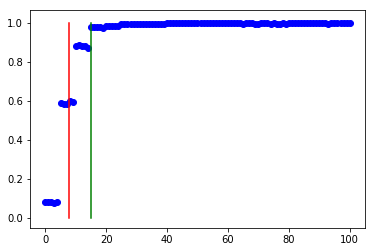

7.66256612539


In [34]:
idx = 3

# see proof here: https://stats.stackexchange.com/questions/10159/find-expected-value-using-cdf
ex = sum(1 - p[idx])

plt.scatter(x=range(101), y=p[idx].tolist(), color = "blue") # cdf predictions

plt.plot((ex, ex), (0, 1), 'k-', color = "red") # expected value of prediction
plt.plot((labels_test_reg[idx], labels_test_reg[idx]), (0, 1), 'k-', color = "green") # true value

plt.show()

print(ex)

In [35]:
pred = np.zeros(p.shape[0])

for i in range(p.shape[0]):
    pred[i] = sum(1 - p[i])

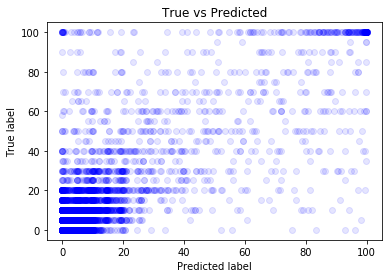

In [36]:
plt.title("True vs Predicted")
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.scatter(x=pred, y=labels_test_reg, color="blue", alpha=0.1)

plt.show()

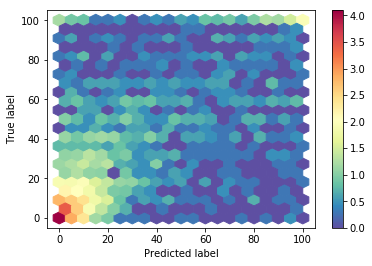

In [43]:
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.hexbin(x=pred, y=labels_test_reg, gridsize=20, bins='log', cmap=plt.cm.Spectral_r)
plt.colorbar()

plt.show()

In [38]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [39]:
mean_absolute_error(y_true=labels_test_reg, y_pred=pred)

3.1192214340977102

In [40]:
mean_squared_error(y_true=labels_test_reg, y_pred=pred)

72.768369127309057

In [41]:
r2_score(y_true=labels_test_reg, y_pred=pred)

0.65274478165075722

In [42]:
from nbconvert import HTMLExporter
import codecs
import nbformat
exporter = HTMLExporter()
output_notebook = nbformat.read('deepxray_regression_crps_original_transfer_learning.ipynb', as_version=4)
output, resources = exporter.from_notebook_node(output_notebook)
codecs.open("/data/joint_scoring/notebooks/" + new_folder + ".html", 'w', encoding='utf-8').write(output)